In [189]:
from fifi_ls.resample import combine_files, get_grid_info, generate_exposure_map
from pypeutils.resampling.resample import Resample
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
import itertools
from mpl_toolkits.mplot3d import Axes3D
from itertools import product, combinations
%matplotlib inline

Replicate what the old pipeline does in IDL:

In [197]:
def load_fits(files, check_header=False):
    """Load FITS data into memory.

    Handles raw data, as well as intermediate data.

    Loaded data are stored in the input attribute.
    """
    from fifi_ls.readfits import readfits

    output = []
    bad_header = ''
    for i, datafile in enumerate(files):

        # read the fits file and standardize/check header
        if check_header:
            input_hdul, success = readfits(datafile,
                                           checkheader=check_header)
        else:
            input_hdul = readfits(datafile,
                                  checkheader=check_header)
            success = True
        if not success:
            bad_header = 'Invalid headers'

        # touch the data to make sure it is in memory
        # and store copies in a new HDUList
        # (this avoids storing a file handle in the HDUList)
        hdul = fits.HDUList()
        for hdu in input_hdul:
            assert hdu.data is None or hdu.data[0] is not None
            hdul.append(hdu.copy())
        input_hdul.close()
        output.append(hdul)

    return output


def get_2d_data():
    files = glob.glob('/Users/dperera/test_data/pacman/reduce/*WSH*')
    # files = glob.glob('/Users/dperera/test_data/fifi-ls/large_wsh/*WSH*')

    hduls = load_fits(files)
    combined = combine_files(hduls)

    xy_oversample = 5.0
    w_oversample = 8.0
    oversample = xy_oversample, w_oversample

    grid_info = get_grid_info(combined, oversample=oversample)
    good_grid = generate_exposure_map(combined, grid_info, get_good=True)
    flxvals = combined['FLUX']
    return flxvals, combined, grid_info, good_grid

flux, combined, grid_info, good_grid = get_2d_data()

INFO: Reading 184 files [fifi_ls.resample]
INFO: Combining and rotating relative to the first file (F0287_FI_IFS_7004082_RED_WSH_200402-200403.fits) [fifi_ls.resample]
INFO: Overall wave min/max (um): 157.265573 158.479148 [fifi_ls.resample]
INFO: Overall X min/max (arcsec): -34.935417 51.923768 [fifi_ls.resample]
INFO: Overall Y min/max (arcsec): -106.568295 106.632794 [fifi_ls.resample]
INFO: Output spectral pixel scale: 0.016445 um [fifi_ls.resample]
INFO: Average spectral FWHM: 0.131560 um [fifi_ls.resample]
INFO: Pixel size for channel: 12.680102 arcsec [fifi_ls.resample]
INFO: Average spatial FWHM for channel: 10.000000 arcsec [fifi_ls.resample]
INFO: Output spatial pixel scale: 2.000000 arcsec/pix [fifi_ls.resample]
INFO: Output grid size (nw, ny, nx): 75x108x44 [fifi_ls.resample]


* For each file:

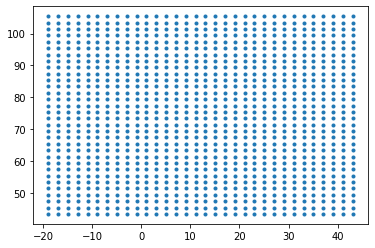

In [198]:
filei = 100
grididx = good_grid[filei]
xg, yg, wout = grid_info['grid']
nx = xg.size
ny = yg.size
nw = wout.size
xgrid = np.resize(xg, (ny, nx))
ygrid = np.resize(yg, (nx, ny)).T
xout, yout = xgrid[grididx], ygrid[grididx]
ws = combined['WAVELENGTH'][filei]
fit_wdw = 0.5 * grid_info['wave_fwhm']
plt.plot(xout, yout, '.')

* Then for each spaxel, fit a spectral profile to regular wavelength grid:

In [199]:
spaxel = 2, 2
s = slice(None), spaxel[0], spaxel[1]

Fit a spectral profile to each spaxel:

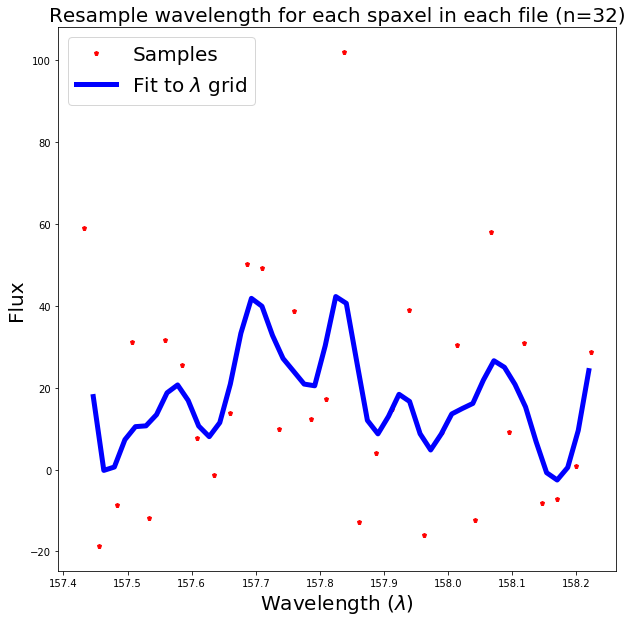

In [200]:
spaxel_flux = combined['FLUX'][filei][s]
spaxel_x = combined['X'][filei][s]
spaxel_y = combined['Y'][filei][s]
spaxel_error = combined['ERROR'][filei][s]
wave = ws[s]
plt.figure(figsize=(10, 10))
plt.plot(wave, spaxel_flux, 'p', color='red', markersize=5,
         label="Samples")
plt.title("Resample wavelength for each spaxel in each file "
          "(n=%i)" % wave.size, size=20)
plt.xlabel(r"Wavelength ($\lambda$)", size=20)
plt.ylabel("Flux", size=20)

# Get fitted value
resampler = Resample(wave, spaxel_flux, error=spaxel_error,
                     window=0.5 * grid_info['wave_fwhm'],
                     mode='edges')
iflux = resampler(wout, smoothing=0.5)
_ = plt.plot(wout, iflux, linewidth=5, color='blue',
             label=r"Fit to $\lambda$ grid")
_ = plt.legend(fontsize=20, loc="upper left")



In [201]:
# Now do this for all spaxels
shape = (nw,) + ws.shape[1:]
iflux, istd = np.empty(shape), np.empty(shape)
for i, j in itertools.product(range(shape[1]), range(shape[2])):
    # all wavelengths, y=i, x=j
    s = slice(None), i, j
    try:
        resampler = Resample(
            ws[s], combined['FLUX'][filei][s],
            error=combined['ERROR'][filei][s],
            window=fit_wdw, order=0, mode='edges')
        iflux[:, i, j] = resampler(wout, smoothing=0.5)
    except (RuntimeError, ValueError, np.linalg.LinAlgError):
        iflux[:, i, j] = np.nan


* Now, resample the single file onto a regular grid in (X, Y):

In [202]:
# Get the distribution first
x = combined['X'][filei][0, :, :]
y = combined['Y'][filei][0, :, :]
minpoints = 10
fidx = np.isfinite(iflux) & np.isfinite(istd)
waveok = np.sum(fidx, axis=(1, 2)) > minpoints
xfull = np.repeat(x[None], fidx.shape[0], axis=0)[fidx]
yfull = np.repeat(y[None], fidx.shape[0], axis=0)[fidx]
wfull = np.empty(fidx.shape)
for i, j in itertools.product(range(shape[1]), range(shape[2])):
    wfull[:, i, j] = wout
wfull = wfull[fidx]


Text(0.5, 0, 'Wavelength')

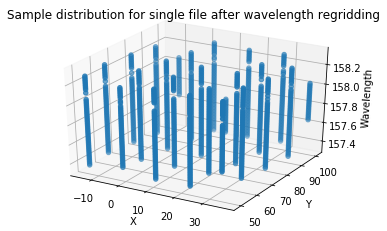

In [203]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xfull.ravel(), yfull.ravel(), wfull.ravel())
plt.title("Sample distribution for single file after wavelength regridding")
plt.xlabel("X")
plt.ylabel("Y")
ax.set_zlabel("Wavelength")

* Plot the stack of planes:

In [204]:
x0 = np.array([combined['X'][filei][0, ...].ravel() for filei in range(combined['X'].shape[0])]).ravel()
y0 = np.array([combined['Y'][filei][0, ...].ravel() for filei in range(combined['Y'].shape[0])]).ravel()
x0 = np.resize(x0, (nw, x0.size))
y0 = np.resize(y0, (nw, y0.size))
w0 = np.resize(wout, (x0.shape[1], nw)).T


def plane(w):
    xx, yy = np.meshgrid(np.linspace(x0.min(), x0.max(), 2),
                         np.linspace(y0.min(), y0.max(), 2))
    zz = xx * 0 + w
    return xx, yy, zz


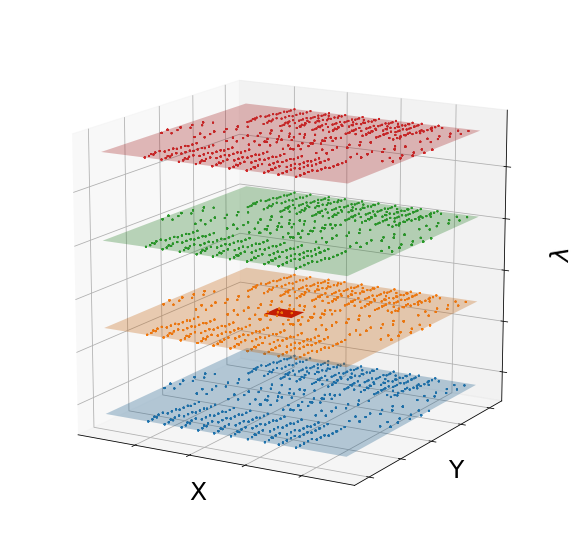

In [251]:
plt3d = plt.figure(figsize=(10, 10)).gca(projection='3d')
for i in range(50, 54):
    w = wout[i]
    plt3d.plot_surface(*plane(w), alpha=0.3)
    ax = plt.gca()
    ax.scatter(x0[i], y0[i], w, s=1)


xr = -0, 10
yr = -10, 10
wr = wout[51]
X, Y, Z = np.meshgrid(xr, yr, wr)
# plt3d.plot_surface(X[:, :, 0], Y[:, :, 0] ,Z[:, :, 0], alpha=1, color='red')
    
    
plt3d.view_init(elev=15)
# plt.title(r"Sample distribution after $\lambda$ resampling", size=20)
# plt.xlabel("X (irregular)", size=20)
# plt.ylabel("Y (irregular)", size=20)
# _ = ax.set_zlabel('\n' + r'$\lambda$ (regular spacing)', linespacing=2, size=20)
plt.xlabel("X", size=25)
plt.ylabel("Y", size=25)
_ = ax.set_zlabel(r'$\lambda$', size=25)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)


* Then for each wavelength slice, interpolate in 2-D (X, Y):

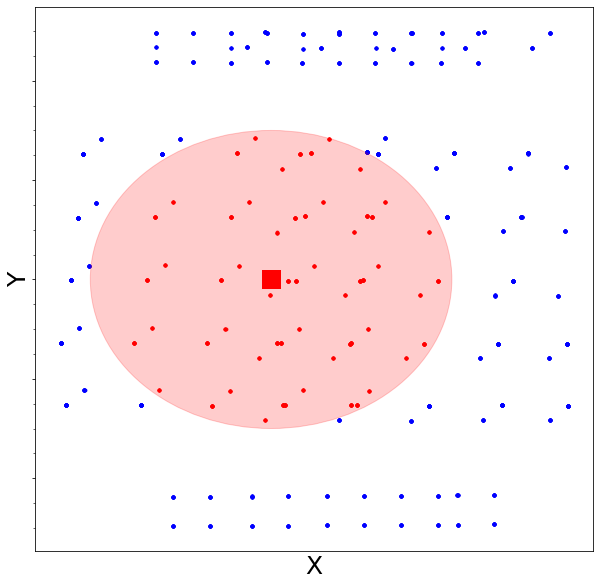

In [376]:
frame = 35
xslice = x0[frame]
yslice = y0[frame]
mask = (xslice >= -50) & (xslice <= 50)
mask &= (yslice >= -50) & (yslice <= 50)
x, y = xslice[mask], yslice[mask]
r = np.sqrt((x ** 2) + (y ** 2))
inrange = r <= 30

d = np.sqrt( ((x / 30) ** 2) + ((y / 30) ** 2))
inside = d <= 1
outside = ~inside


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x[outside], y[outside], s=8, color='blue')
ax.scatter(x[inside], y[inside], s=8, color='red', alpha=0.5)

ax.set_xticks(np.arange(-40, 60, 20))
ax.set_xticks(np.arange(-40, 60, 5), minor=True)
ax.set_yticks(np.arange(-140, 140, 20))
_ = ax.set_yticks(np.arange(-140, 140, 5), minor=True)
ax.plot(0, 0, 's', color='red', markersize=12, mew=7, label="Pixel")
circle = Circle((0, 0), radius=30, fill=True, lw=1,
                alpha=0.2, color='red', label="Fit radius")
ax.add_patch(circle)
plt.xlabel("X", size=25)
plt.ylabel("Y", size=25)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
# Yes, I counted since I don't want to write compflux2d again
# plt.title("Resample irregular (X, Y) to regular pixels (n=60)", size=20)
# _ = plt.legend(loc='upper right', fontsize=20)

- Now onto 3-D:

In [207]:
def get_data():
    files = glob.glob('/Users/dperera/test_data/pacman/reduce/*WSH*')
    # files = glob.glob('/Users/dperera/test_data/fifi-ls/large_wsh/*WSH*')

    global combined
    if combined is None:
        hduls = load_fits(files)
        combined = combine_files(hduls)

    xy_oversample = 5.0
    w_oversample = 8.0
    oversample = xy_oversample, w_oversample
    grid = get_grid_info(combined, oversample=oversample)

    window = [3.0, 3.0, 0.5]
    fit_wdw = \
        (window[0] * grid['xy_fwhm'],
         window[1] * grid['xy_fwhm'],
         window[2] * grid['wave_fwhm'])
    flxvals = np.hstack([f.ravel() for f in combined['FLUX']])
    errvals = np.hstack([e.ravel() for e in combined['ERROR']])

    init_params = {
        'robust': None,
        'error': errvals,
        'fix_order': False,
        'negthresh': None,
        'mode': 'edges',
        'order': 2,
        'window': fit_wdw,
    }

    call_params = {
        'fit_threshold': 0.0,
        'edge_threshold': (0.7, 0.7, 0.5),
        'error_weighting': True,
        'edge_algorithm': 'com_distance',
        'get_error': True,
        'get_counts': True,
        'jobs': -2,
        'client': None
    }
    return flxvals, combined, init_params, call_params


In [208]:
flxvals, combined, init_params, call_params = get_data()
xy_oversample = 5.0
w_oversample = 8.0
oversample = xy_oversample, w_oversample
grid_info = get_grid_info(combined, oversample=oversample)
init = init_params.copy()
call = call_params.copy()
coordinates = grid_info['coordinates'].copy()
grid = grid_info['grid']  # everything on fine
resampler = Resample(coordinates.copy(), flxvals, **init)

INFO: Overall wave min/max (um): 157.265573 158.479148 [fifi_ls.resample]
INFO: Overall X min/max (arcsec): -34.935417 51.923768 [fifi_ls.resample]
INFO: Overall Y min/max (arcsec): -106.568295 106.632794 [fifi_ls.resample]
INFO: Output spectral pixel scale: 0.016445 um [fifi_ls.resample]
INFO: Average spectral FWHM: 0.131560 um [fifi_ls.resample]
INFO: Pixel size for channel: 12.680102 arcsec [fifi_ls.resample]
INFO: Average spatial FWHM for channel: 10.000000 arcsec [fifi_ls.resample]
INFO: Output spatial pixel scale: 2.000000 arcsec/pix [fifi_ls.resample]
INFO: Output grid size (nw, ny, nx): 75x108x44 [fifi_ls.resample]
INFO: Overall wave min/max (um): 157.265573 158.479148 [fifi_ls.resample]
INFO: Overall X min/max (arcsec): -34.935417 51.923768 [fifi_ls.resample]
INFO: Overall Y min/max (arcsec): -106.568295 106.632794 [fifi_ls.resample]
INFO: Output spectral pixel scale: 0.016445 um [fifi_ls.resample]
INFO: Average spectral FWHM: 0.131560 um [fifi_ls.resample]
INFO: Pixel size fo

- Start plotting:

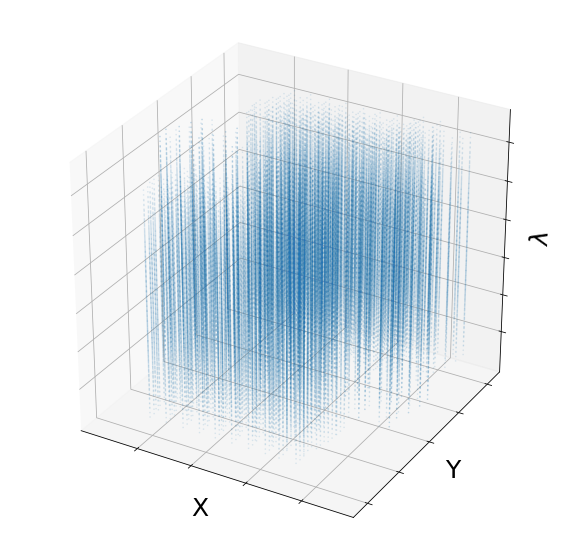

In [253]:
plt3d = plt.figure(figsize=(10, 10)).gca(projection='3d')
plt3d.scatter(*coordinates, s=0.5, cmap='jet', alpha=0.1)
# plt.title(r"Irregular cloud of data samples in (X, Y, $\lambda$)", size=20)
plt.xlabel("X", size=25)
plt.ylabel("Y", size=25)
plt3d.view_init(elev=30)
# _ = plt3d.set_zlabel('\n' + r'$\lambda$', linespacing=2, size=20)
_ = plt3d.set_zlabel(r'$\lambda$', size=25)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)

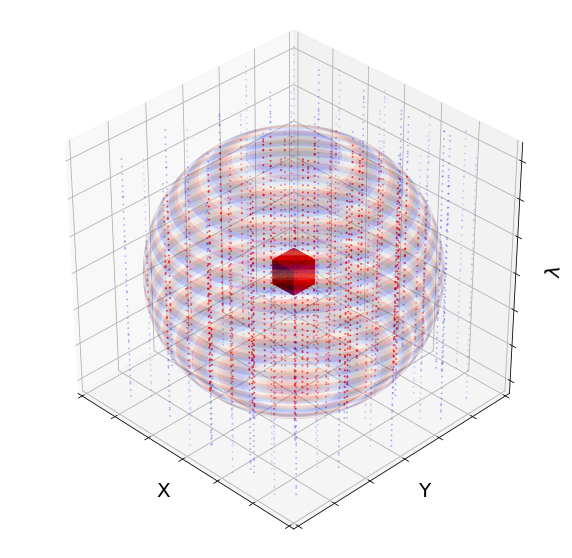

In [367]:
xlim = -30, 30
ylim = -30, 30
wcen = wout[35]
wlam = init['window'][2]
wlim = wcen - wlam, wcen + wlam

mask = (coordinates[0] >= xlim[0]) & (coordinates[0] <= xlim[1])
mask &= (coordinates[1] >= ylim[0]) & (coordinates[1] <= ylim[1])
mask &= (coordinates[2] >= wlim[0]) & (coordinates[2] <= wlim[1])

c = coordinates[:, mask].copy()

plt3d = plt.figure(figsize=(10, 10)).gca(projection='3d')
# plt3d.scatter(*c, s=1, color='blue', alpha=0.2)

w = init['window']
d = np.sqrt(((c[0] / w[0]) ** 2) +
            ((c[1] / w[1]) ** 2) +
            (((c[2]  - wcen)/ w[2]) ** 2))
inside = d <= 1
outside = ~inside
plt3d.scatter(*c[:, outside], s=1, color='blue', alpha=0.1)
plt3d.scatter(*c[:, inside], s=1, color='red', alpha=0.4)


xgrid, ygrid, zgrid = np.meshgrid(*grid)

# Plot the voxel
xr = -3, 3
yr = -3, 3
wr = (wcen - wlam * 0.1), (wcen + wlam * 0.1)
X, Y, Z = np.meshgrid(xr, yr, wr)

plt3d.plot_surface(X[:, :, 0], Y[:, :, 0] ,Z[:, :, 0], alpha=1, color='red')
plt3d.plot_surface(X[:, :, 0], Y[:, :, 0] ,Z[:, :, 1], alpha=1, color='red')
plt3d.plot_surface(X[:, 0, :], Y[:, 0, :] ,Z[:, 0, :], alpha=1, color='red')
plt3d.plot_surface(X[:, 1, :], Y[:, 1, :] ,Z[:, 1, :], alpha=1, color='red')
plt3d.plot_surface(X[0, :, :], Y[0, :, :] ,Z[0, :, :], alpha=1, color='red')
plt3d.plot_surface(X[1, :, :], Y[1, :, :] ,Z[1, :, :], alpha=1, color='red')


# Plot the elipsoid
from matplotlib import cm
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
sx = init['window'][0] * np.outer(np.cos(u), np.sin(v))
sy = init['window'][1] * np.outer(np.sin(u), np.sin(v))
sz = init['window'][2] * np.outer(np.ones_like(u), np.cos(v)) + wcen
plt3d.plot_surface(sx, sy, sz, rstride=1, cstride=1, alpha=0.15,
                   cmap=cm.flag)

plt3d.view_init(elev=35, azim=-45)

resampler = Resample(coordinates.copy(), np.ones(flxvals.shape), **init)
_, counts = resampler(0, 0, wcen, get_counts=True)
# plt.title(r"Resample irregular (X, Y, $\lambda$) to regular voxels (n=%i)" % counts, size=20)
# plt.xlabel("X (irregular)", size=20)
# plt.ylabel("Y (irregular)", size=20)
plt.xlabel("X", size=20)
plt.ylabel("Y", size=20)
_ = plt3d.set_zlabel(r'$\lambda$', size=20)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt3d.set_xlim(-30, 30)
plt3d.set_ylim(-30, 30)
_ = plt3d.set_zlim(wcen - wlam, wcen + wlam)


In [363]:
d.min()

0.09472650970031955

- Finally, represent voxel grid:

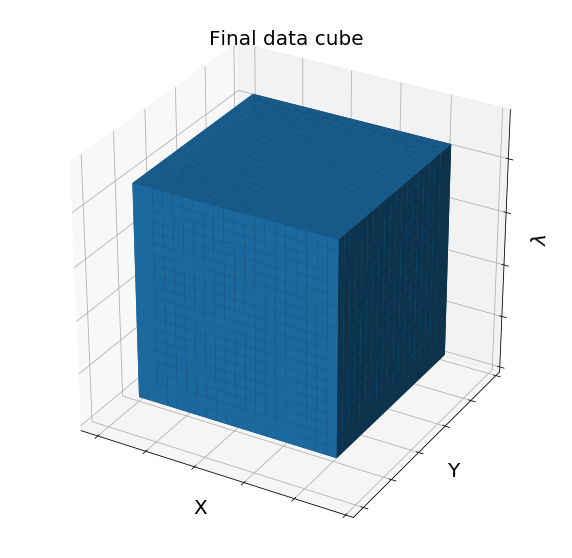

In [263]:
# gx, gy, gz = np.indices((grid[0].size + 10, grid[1].size + 10, grid[2].size + 10))
# AHHH matplotlib can't handle this... create fake grid
gx, gy, gz = np.indices((24, 24, 24))
voxels = np.full(gx.shape, True)
voxels[:2] = False
voxels[-2:] = False
voxels[:, :2] = False
voxels[:, -2:] = False
voxels[..., :2] = False
voxels[..., -2:] = False
voxels[3:21, 3:21, 3:21] = False
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.voxels(voxels)
plt.tick_params(axis='both', which='both', bottom=False, top=False,
                labelbottom=False, labeltop=False, labelleft=False, labelright=False)
plt.title("Final data cube", size=20)
plt.xlabel("X", size=20)
plt.ylabel("Y", size=20)
ax.set_zlabel(r'$\lambda$', size=20)
plt.show()

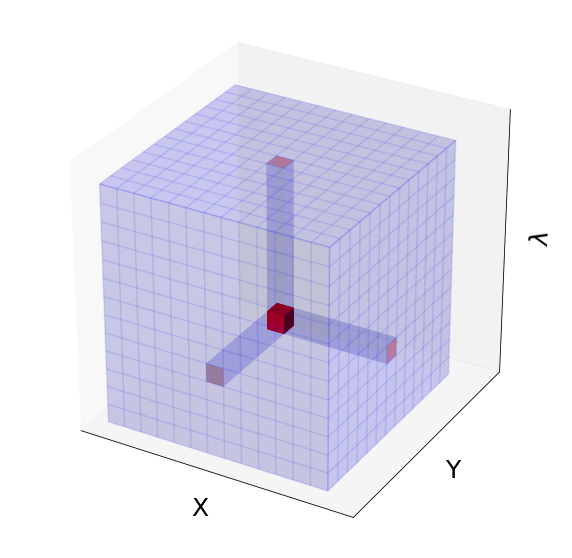

In [331]:
xr = np.arange(0, 14)
yr = np.arange(0, 14)
wr = np.arange(0, 14)
X, Y, Z = np.meshgrid(xr, yr, wr)
plt3d = plt.figure(figsize=(10, 10)).gca(projection='3d')

mkwargs = {'alpha': 0.1, 'color': 'blue', 'rstride': 1, 'cstride': 1}
plt3d.plot_wireframe(X[:, :, -1], Y[:, :, -1] ,Z[:, :, -1], **mkwargs)
plt3d.plot_wireframe(X[:, -1, :], Y[:, -1, :] ,Z[:, -1, :], **mkwargs)
plt3d.plot_wireframe(X[0, :, :], Y[0, :, :] ,Z[0, :, :], **mkwargs)

skwargs = {'alpha': 0.05, 'color': 'blue'}
plt3d.plot_surface(X[:, :, 0], Y[:, :, 0] ,Z[:, :, 0], **mkwargs)
plt3d.plot_surface(X[:, :, -1], Y[:, :, -1] ,Z[:, :, -1], **mkwargs)
plt3d.plot_surface(X[:, 0, :], Y[:, 0, :] ,Z[:, 0, :], **mkwargs)
plt3d.plot_surface(X[:, -1, :], Y[:, -1, :] ,Z[:, 1, :], **mkwargs)
plt3d.plot_surface(X[0, :, :], Y[0, :, :] ,Z[0, :, :], **mkwargs)
plt3d.plot_surface(X[-1, :, :], Y[-1, :, :] ,Z[-1, :, :], **mkwargs)

# Voxel
gx, gy, gz = np.indices((14, 14, 14))
voxels = np.full(gx.shape, False)
voxels[6, 6, 4] = True
plt3d.voxels(voxels, facecolors='red', shade=True)

# Lines

face = {'alpha': 0.3, 'color': 'red'}
sides = {'alpha': 0.1, 'color': 'blue'}
plt3d.plot_surface(X[6:8, 6:8, -1], Y[6:8, 6:8, -1] ,Z[6:8, 6:8, -1], **face)
plt3d.plot_surface(X[6:8, 6, 5:], Y[6:8, 6, 5:] ,Z[6:8, 6, 5:], **sides)
plt3d.plot_surface(X[6:8, 7, 5:], Y[6:8, 7, 5:] ,Z[6:8, 7, 5:], **sides)
plt3d.plot_surface(X[6, 6:8, 5:], Y[6, 6:8, 5:] ,Z[6, 6:8, 5:], **sides)
plt3d.plot_surface(X[7, 6:8, 5:], Y[7, 6:8, 5:] ,Z[7, 6:8, 5:], **sides)

plt3d.plot_surface(X[6:8, -1, 4:6], Y[6:8, -1, 4:6] ,Z[6:8, -1, 4:6], **face)
plt3d.plot_surface(X[6:8, 7:, 5], Y[6:8, 7:, 5] ,Z[6:8, 7:, 5], **sides)
plt3d.plot_surface(X[6:8, 7:, 4], Y[6:8, 7:, 4] ,Z[6:8, 7:, 4], **sides)
plt3d.plot_surface(X[6, 7:, 4:6], Y[6, 7:, 4:6] ,Z[6, 7:, 4:6], **sides)
plt3d.plot_surface(X[7, 7:, 4:6], Y[7, 7:, 4:6] ,Z[7, 7:, 4:6], **sides)

plt3d.plot_surface(X[0, 6:8, 4:6], Y[0, 6:8, 4:6] ,Z[0, 6:8, 4:6], **face)
plt3d.plot_surface(X[:7, 6:8, 4], Y[:7, 6:8, 4] ,Z[:7, 6:8, 4], **sides)
plt3d.plot_surface(X[:7, 6:8, 5], Y[:7, 6:8, 5] ,Z[:7, 6:8, 5], **sides)
plt3d.plot_surface(X[:7, 6, 4:6], Y[:7, 6, 4:6] ,Z[:7, 6, 4:6], **sides)
plt3d.plot_surface(X[:7, 7, 4:6], Y[:7, 7, 4:6] ,Z[:7, 7, 4:6], **sides)

#plt3d.plot_surface(X[6, 7:, 4:6], Y[6, 7:, 4:6] ,Z[6, 7:, 4:6], **skwargs)
#plt3d.plot_surface(X[7, 7:, 4:6], Y[7, 7:, 4:6] ,Z[7, 7:, 4:6], **skwargs)


plt3d.grid(False)

# Hide axes ticks
plt3d.set_xticks([])
plt3d.set_yticks([])
plt3d.set_zticks([])

plt.xlabel("X", size=25)
plt.ylabel("Y", size=25)
_ = plt3d.set_zlabel(r'$\lambda$', size=25)